In [ ]:
import pandas as pd
import io
dataset = pd.read_excel("/content/preprocessed_excel_file.xlsx")
#corpus.drop(corpus[corpus['Class Label'] ==2].index, inplace = True)
#len(dataset)
df=dataset
len(dataset)

6840

In [ ]:
dataset.head(5)

,Original Texts,Normalized Texts,Negative,Neutral,Positive,Compound Score,Class Label
0,As an Indian I understand the issue of Indones...,indian understand issue indonesia,0.000,1.000,0.000,0.0000,2
1,No country should take them,country,0.355,0.645,0.000,-0.2960,1
2,Rohingyas belong to Bangladesh. Why not the ri...,rohingyas belong bangladesh rich islamic count...,0.173,0.650,0.177,0.0196,2
3,We have 57 islamic countries but all muslim pe...,islamic countries muslim people talking follow...,0.000,1.000,0.000,0.0000,2
4,As an Indian bordering Myanmar and Bangladesh,indian bordering myanmar bangladesh,0.000,1.000,0.000,0.0000,2


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import wordnet as wn
wn.synset('refugee.n.01').lowest_common_hypernyms(wn.synset('bangladesh.n.01'))

[Synset('object.n.01')]

In [ ]:
wn.synsets('refugee')

In [ ]:
# Run in python console
import nltk; nltk.download('stopwords')

# Run in terminal or command prompt
!python3 -m spacy download en

In [ ]:
# prompt: delete null values in the dataset

dataset = dataset.dropna()
len(dataset)


6701

In [ ]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
!pip install pyldavis

In [ ]:
len(dataset)

6701

In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [ ]:
!pip show sklearn

In [ ]:
!pip show sklearn

In [ ]:
# spacy for lemmatization
import spacy

# Plotting tools
#import pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [ ]:
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'DejaVu Sans'

In [ ]:
# Prepare Stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(dataset['Normalized Texts']))

#print(data_words)

In [ ]:
print(data_words)

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  # min_count (float, optional) – Ignore all words and bigrams with total collected count lower than this value.

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[data_words[0]])

**min_count (float, optional)** – Ignore all words and bigrams with total collected count lower than this value.

**threshold (float, optional)** – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

**threshold (float, optional)** – Represent a score threshold for forming the phrases (higher means fewer phrases). A phrase of words a followed by b is accepted if the score of the phrase is greater than threshold. Heavily depends on concrete scoring-function, see the scoring parameter.

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# from tigrams
data_words_trigrams=make_trigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[:2])

In [ ]:
data_lemmatized

**corpus** is the final dataset that will be used to find the topic.
We first generated all the bigrams in the normalized text dataset and then filtered out those words or phrases that appeared less than 5 times. Finally, we used bag of words approach to count the frequency of each word within each document/news.

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency; each unique word (id) with frequency in each doc using bag of words
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:2])

In [ ]:
data_words[:2]

[['indian', 'understand', 'issue', 'indonesia'], ['country']]

In [ ]:
print(corpus[:2])

[[], [(0, 1)]]


In [ ]:
len(id2word)

5369

In [ ]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

In [ ]:
def train_model(num_topic):
  lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topic,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.5,
                                           eta=0.01,
                                           per_word_topics=True)
  # Compute Coherence Score
  coherence = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_lda = coherence.get_coherence()
  print('{}={:.03f}' .format(num_topic,coherence_lda))
  #print(lda_model.alpha)


In [ ]:
  train_model(20)

In [ ]:
for topic_num in range(1,31):
  train_model(topic_num)
  #print(topic_num)

1=0.368
2=0.254
3=0.406
4=0.420
5=0.490
6=0.479
7=0.518
8=0.531
9=0.550
10=0.560
11=0.567
12=0.569
13=0.587
14=0.594
15=0.598
16=0.589
17=0.587
18=0.592
19=0.590
20=0.593
21=0.585
22=0.573
23=0.586
24=0.581
25=0.574
26=0.564
27=0.568
28=0.566
29=0.571
30=0.568


In [ ]:
import zipfile #handling zip files
import shutil # funtionality of file operation such as moving files

# Extract the Arial font zip file
with zipfile.ZipFile('/content/arial-font.zip', 'r') as zip_ref:
    zip_ref.extractall('arial_font')

# Move Arial font file to the fonts directory
shutil.move('arial_font/arial.ttf', '/usr/share/fonts/truetype/arial.ttf')

# Clear font cache
!fc-cache -f -v


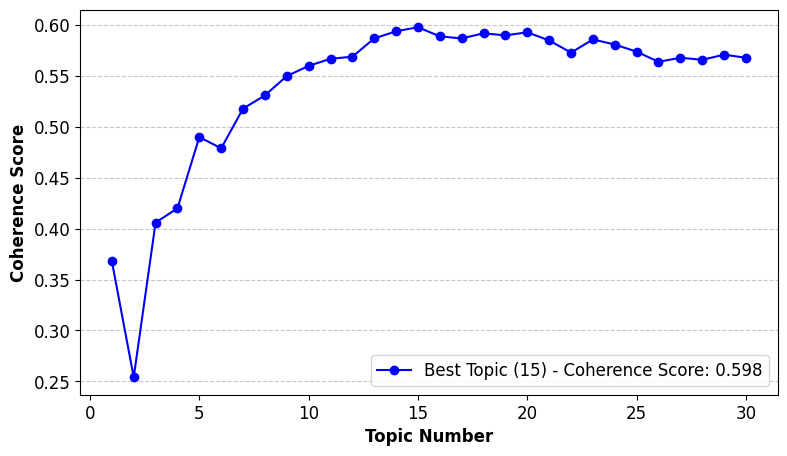

In [ ]:
import matplotlib.pyplot as plt

# Your dataset
topics = list(range(1, 31))
coherence_scores = [0.368, 0.254, 0.406, 0.420, 0.490, 0.479, 0.518, 0.531, 0.550, 0.560,
                    0.567, 0.569, 0.587, 0.594, 0.598, 0.589, 0.587, 0.592, 0.590, 0.593,
                    0.585, 0.573, 0.586, 0.581, 0.574, 0.564, 0.568, 0.566, 0.571, 0.568]

# Find the index of the maximum coherence score
best_topic_index = coherence_scores.index(max(coherence_scores))
best_coherence_score = max(coherence_scores)

# Creating the line graph with annotation
plt.figure(figsize=(9, 5))
plt.plot(topics, coherence_scores, marker='o', linestyle='-', color='b', label='Coherence Scores')
plt.scatter(best_topic_index + 1, best_coherence_score, color='red', marker='*')
plt.xlabel('Topic Number',weight='bold')
plt.ylabel('Coherence Score',weight='bold')
#plt.title('Coherence Scores for Different Topics')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend([f'Best Topic ({best_topic_index + 1}) - Coherence Score: {best_coherence_score:.3f}'])

# Display the graph
plt.show()


In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.5,
                                           eta=0.01,
                                           per_word_topics=True)
coherence = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence.get_coherence()
print('{:.03f}' .format(coherence_lda))

0.589


In [ ]:
print(lda_model.alpha)


In [ ]:
beta = lda_model.get_topics()
# Find the smallest and largest beta values
smallest_beta = np.min(beta)
largest_beta = np.max(beta)

print("Smallest beta value:", smallest_beta) # 0.00002
print("Largest beta value:", largest_beta) # 0.7954797

print("\n")
eta = lda_model.eta

# Find the smallest and largest eta values
smallest_eta = np.min(eta)
largest_eta = np.max(eta)

print("Smallest eta value:", smallest_eta) # 0.02683891
print("Largest eta value:", largest_eta) # 0.035350747

print("\n")

alpha = lda_model.alpha

# Find the smallest and largest alpha values
smallest_alpha = min(alpha)
largest_alpha = max(alpha)

print("Smallest alpha value:", smallest_alpha)
print("Largest alpha value:", largest_alpha)

Smallest beta value: 4.8702586e-06
Largest beta value: 0.8559495


Smallest eta value: 0.01
Largest eta value: 0.01


Smallest alpha value: 1.0
Largest alpha value: 1.0


In [ ]:
import gensim
from gensim.models import CoherenceModel
import numpy as np

def train_model(corpus, id2word, data_lemmatized, num_topic, alpha, eta):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topic,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha=alpha,
                                       eta=eta,
                                       per_word_topics=True)

    coherence_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f'Num Topics: {num_topic}, Alpha: {alpha}, Eta: {eta}, Coherence Score: {coherence_score:.3f}')

    return coherence_score

# Define the range of values for alpha and eta
alpha_values = [0.01, 0.1, 0.5, 1.0]
eta_values = [0.01, 0.1, 0.5, 1.0]

best_coherence = -1
best_alpha = None
best_eta = None

# Perform grid search
for alpha in alpha_values:
    for eta in eta_values:
        coherence_score = train_model(corpus, id2word, data_lemmatized, num_topic=16, alpha=alpha, eta=eta)
        if coherence_score > best_coherence:
            best_coherence = coherence_score
            best_alpha = alpha
            best_eta = eta

print(f'Best Alpha: {best_alpha}, Best Eta: {best_eta}, Best Coherence Score: {best_coherence:.3f}')


Num Topics: 16, Alpha: 0.01, Eta: 0.01, Coherence Score: 0.569
Num Topics: 16, Alpha: 0.01, Eta: 0.1, Coherence Score: 0.492
Num Topics: 16, Alpha: 0.01, Eta: 0.5, Coherence Score: 0.463
Num Topics: 16, Alpha: 0.01, Eta: 1.0, Coherence Score: 0.430
Num Topics: 16, Alpha: 0.1, Eta: 0.01, Coherence Score: 0.574
Num Topics: 16, Alpha: 0.1, Eta: 0.1, Coherence Score: 0.498
Num Topics: 16, Alpha: 0.1, Eta: 0.5, Coherence Score: 0.479
Num Topics: 16, Alpha: 0.1, Eta: 1.0, Coherence Score: 0.440
Num Topics: 16, Alpha: 0.5, Eta: 0.01, Coherence Score: 0.589
Num Topics: 16, Alpha: 0.5, Eta: 0.1, Coherence Score: 0.488
Num Topics: 16, Alpha: 0.5, Eta: 0.5, Coherence Score: 0.433
Num Topics: 16, Alpha: 0.5, Eta: 1.0, Coherence Score: 0.496
Num Topics: 16, Alpha: 1.0, Eta: 0.01, Coherence Score: 0.597
Num Topics: 16, Alpha: 1.0, Eta: 0.1, Coherence Score: 0.505
Num Topics: 16, Alpha: 1.0, Eta: 0.5, Coherence Score: 0.434
Num Topics: 16, Alpha: 1.0, Eta: 1.0, Coherence Score: 0.417
Best Alpha: 1.0,

In [ ]:
import gensim
from gensim.models import CoherenceModel
import numpy as np

def train_model(corpus, id2word, data_lemmatized, num_topics, alpha, eta):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=100,
                                       update_every=1,
                                       chunksize=100,
                                       passes=10,
                                       alpha=alpha,
                                       eta=eta,
                                       per_word_topics=True)

    coherence_model = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f'Num Topics: {num_topics}, Alpha: {alpha}, Eta: {eta}, Coherence Score: {coherence_score:.3f}')

    return coherence_score

# Define the range of values for alpha, eta, and number of topics
alpha_values = [0.01, 0.1, 0.5, 1.0]
eta_values = [0.01, 0.1, 0.5, 1.0]
num_topics_values = [5, 10, 15, 20]

best_coherence = -1
best_alpha = None
best_eta = None
best_num_topics = None

# Perform grid search
for num_topics in num_topics_values:
    for alpha in alpha_values:
        for eta in eta_values:
            coherence_score = train_model(corpus, id2word, data_lemmatized, num_topics=num_topics, alpha=alpha, eta=eta)
            if coherence_score > best_coherence:
                best_coherence = coherence_score
                best_alpha = alpha
                best_eta = eta
                best_num_topics = num_topics

print(f'Best Num Topics: {best_num_topics}, Best Alpha: {best_alpha}, Best Eta: {best_eta}, Best Coherence Score: {best_coherence:.3f}')


Num Topics: 5, Alpha: 0.01, Eta: 0.01, Coherence Score: 0.446
Num Topics: 5, Alpha: 0.01, Eta: 0.1, Coherence Score: 0.379
Num Topics: 5, Alpha: 0.01, Eta: 0.5, Coherence Score: 0.366
Num Topics: 5, Alpha: 0.01, Eta: 1.0, Coherence Score: 0.479
Num Topics: 5, Alpha: 0.1, Eta: 0.01, Coherence Score: 0.436
Num Topics: 5, Alpha: 0.1, Eta: 0.1, Coherence Score: 0.392
Num Topics: 5, Alpha: 0.1, Eta: 0.5, Coherence Score: 0.402
Num Topics: 5, Alpha: 0.1, Eta: 1.0, Coherence Score: 0.426
Num Topics: 5, Alpha: 0.5, Eta: 0.01, Coherence Score: 0.490
Num Topics: 5, Alpha: 0.5, Eta: 0.1, Coherence Score: 0.372
Num Topics: 5, Alpha: 0.5, Eta: 0.5, Coherence Score: 0.344
Num Topics: 5, Alpha: 0.5, Eta: 1.0, Coherence Score: 0.353
Num Topics: 5, Alpha: 1.0, Eta: 0.01, Coherence Score: 0.449
Num Topics: 5, Alpha: 1.0, Eta: 0.1, Coherence Score: 0.343
Num Topics: 5, Alpha: 1.0, Eta: 0.5, Coherence Score: 0.366
Num Topics: 5, Alpha: 1.0, Eta: 1.0, Coherence Score: 0.331
Num Topics: 10, Alpha: 0.01, Eta

Num Topics: 5, Best Alpha: 0.5, Best Eta: 0.01, Best Coherence Score: 0.490 \\
Num Topics: 10, Best Alpha: 1.0, Best Eta: 0.01, Best Coherence Score: 0.585 \\
Num Topics: 15, Best Alpha: 0.5, Best Eta: 0.01, Best Coherence Score: 0.598 \\
Num Topics: 20, Best Alpha: 0.5, Best Eta: 0.01, Best Coherence Score: 0.593

**chunksize (int, optional)** – Number of documents to be used in each training chunk.


passes (int, optional) **bold text** – Number of passes through the corpus during training.

In [ ]:
coherence_lda = coherence.get_coherence()
print('{:.03f}' .format(coherence_lda))

0.598


In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]
doc_lda

[(0,
  '0.308*"child" + 0.186*"family" + 0.178*"time" + 0.106*"hope" + '
  '0.042*"birth" + 0.028*"donation" + 0.022*"imagine" + 0.021*"kick" + '
  '0.004*"adult" + 0.004*"forever"'),
 (1,
  '0.780*"refugee" + 0.125*"rohingya" + 0.042*"care" + 0.020*"claim" + '
  '0.000*"landslide" + 0.000*"fisherman" + 0.000*"inspiration" + '
  '0.000*"thunder" + 0.000*"wind" + 0.000*"flash"'),
 (2,
  '0.273*"situation" + 0.158*"rohingyas" + 0.148*"instead" + 0.117*"stay" + '
  '0.091*"island" + 0.000*"landslide" + 0.000*"academic" + 0.000*"wind" + '
  '0.000*"flash" + 0.000*"thunder"'),
 (3,
  '0.326*"home" + 0.184*"leave" + 0.103*"welcome" + 0.090*"respect" + '
  '0.077*"local" + 0.071*"pay" + 0.000*"flash" + 0.000*"thunder" + '
  '0.000*"fisherman" + 0.000*"academic"'),
 (4,
  '0.146*"boat" + 0.135*"islamic" + 0.134*"religion" + 0.134*"talk" + '
  '0.071*"come" + 0.068*"buddhist" + 0.049*"arrive" + 0.047*"ethnicity" + '
  '0.033*"follow" + 0.023*"enemy"'),
 (5,
  '0.632*"country" + 0.066*"enter" + 

In [ ]:
#Print the salient terms with probability of each topic/relavence score of words in each topic
for topic_id in range(lda_model.num_topics):
    print(f"Topic {topic_id}:")
    for term_id, prob in lda_model.get_topic_terms(topic_id):
        term = id2word.get(term_id)
        print(f"{term} ({prob:.2f})")
    print()

Topic 0:
child (0.31)
family (0.19)
time (0.18)
hope (0.11)
birth (0.04)
donation (0.03)
imagine (0.02)
kick (0.02)
adult (0.00)
forever (0.00)

Topic 1:
refugee (0.78)
rohingya (0.13)
care (0.04)
claim (0.02)
landslide (0.00)
fisherman (0.00)
inspiration (0.00)
thunder (0.00)
wind (0.00)
flash (0.00)

Topic 2:
situation (0.27)
rohingyas (0.16)
instead (0.15)
stay (0.12)
island (0.09)
landslide (0.00)
academic (0.00)
wind (0.00)
flash (0.00)
thunder (0.00)

Topic 3:
home (0.33)
leave (0.18)
welcome (0.10)
respect (0.09)
local (0.08)
pay (0.07)
flash (0.00)
thunder (0.00)
fisherman (0.00)
academic (0.00)

Topic 4:
boat (0.15)
islamic (0.13)
religion (0.13)
talk (0.13)
come (0.07)
buddhist (0.07)
arrive (0.05)
ethnicity (0.05)
follow (0.03)
enemy (0.02)

Topic 5:
country (0.63)
enter (0.07)
watch (0.05)
learn (0.05)
carry (0.03)
hard (0.03)
house (0.03)
demand (0.02)
academic (0.00)
flash (0.00)

Topic 6:
bangladesh (0.63)
help (0.26)
free (0.03)
say (0.02)
wait (0.02)
hypocrite (0.01)
s

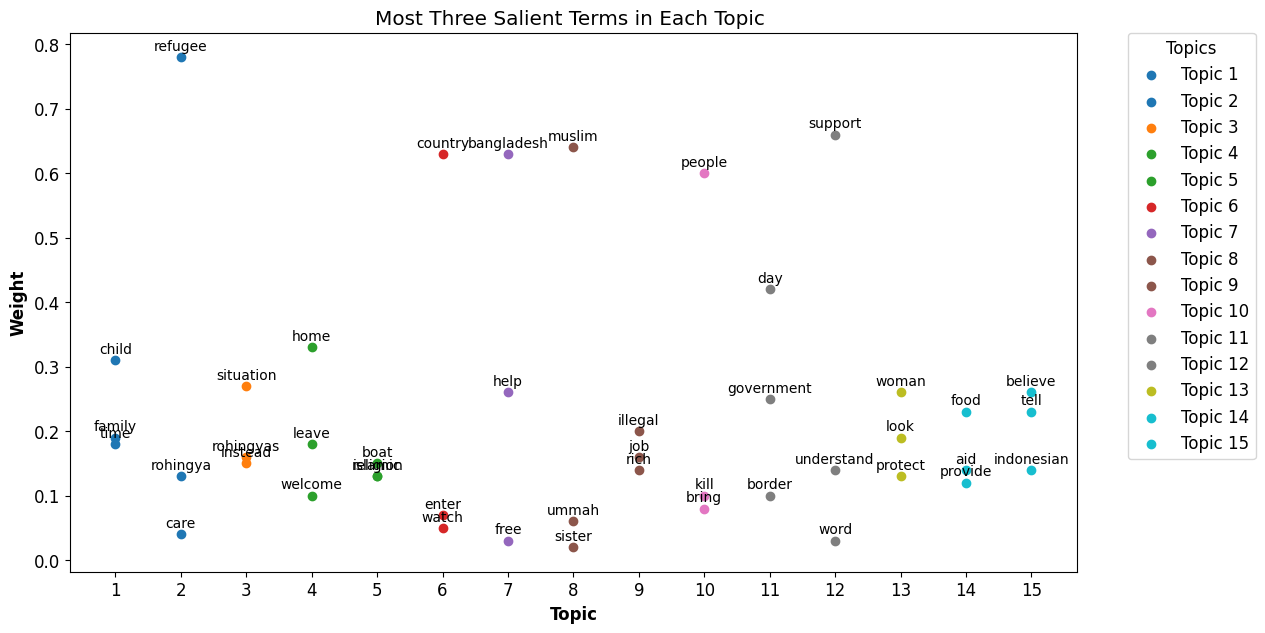

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual data)
topics = ['Topic 0', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14']
terms = ['child', 'family', 'time', 'refugee', 'rohingya', 'care', 'situation', 'rohingyas', 'instead', 'home', 'leave', 'welcome', 'boat', 'islamic', 'religion', 'country', 'enter', 'watch', 'bangladesh', 'help', 'free', 'muslim', 'ummah', 'sister', 'illegal', 'job', 'rich', 'people', 'kill', 'bring', 'day', 'government', 'border', 'support', 'understand', 'word', 'woman', 'look', 'protect', 'food', 'aid', 'provide', 'believe', 'tell', 'indonesian']
weights = [0.31, 0.19, 0.18, 0.78, 0.13, 0.04, 0.27, 0.16, 0.15, 0.33, 0.18, 0.10, 0.15, 0.13, 0.13, 0.63, 0.07, 0.05, 0.63, 0.26, 0.03, 0.64, 0.06, 0.02, 0.20, 0.16, 0.14, 0.60, 0.10, 0.08, 0.42, 0.25, 0.10, 0.66, 0.14, 0.03, 0.26, 0.19, 0.13, 0.23, 0.14, 0.12, 0.26, 0.23, 0.14]

# Separate data into topics
topic_data = {topic: {'terms': [], 'weights': []} for topic in topics}
for i, term in enumerate(terms):
    topic = topics[i // 3]
    topic_data[topic]['terms'].append(term)
    topic_data[topic]['weights'].append(weights[i])

# Create a scatter plot
plt.figure(figsize=(13, 7))
colors = plt.cm.get_cmap('tab10', len(topics))

for i, topic in enumerate(topics):
    x_values = [i + 1] * 3
    y_values = topic_data[topic]['weights']
    labels = topic_data[topic]['terms']

    plt.scatter(x_values, y_values, label=f'Topic {i + 1}', color=colors(i))
    for label, x, y in zip(labels, x_values, y_values):
        plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=10)

plt.xlabel('Topic', weight='bold')
plt.xticks(np.arange(1, len(topics) + 1))
plt.ylabel('Weight', weight='bold')
plt.title('Most Three Salient Terms in Each Topic ')
plt.legend(title='Topics', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


In [ ]:

# Loop over each topic in the model
for topic_id in range(lda_model.num_topics):

    # Get the top n words in the topic, along with their probabilities
    topn_words = lda_model.show_topic(topic_id, topn=10)

    # Reverse the order of the list and select the last element
    least_prob_word = topn_words[::1][0]

    # Print the least/most probable word and its probability
    print(f"Topic {topic_id+1}: {least_prob_word[0]} ({least_prob_word[1]})")


Topic 1: child (0.30843520164489746)
Topic 2: refugee (0.7802063822746277)
Topic 3: situation (0.27284368872642517)
Topic 4: home (0.3256678581237793)
Topic 5: boat (0.1459781378507614)
Topic 6: country (0.6320014595985413)
Topic 7: bangladesh (0.6316475868225098)
Topic 8: muslim (0.637489914894104)
Topic 9: illegal (0.19758431613445282)
Topic 10: people (0.5992607474327087)
Topic 11: day (0.4211226999759674)
Topic 12: support (0.6552962064743042)
Topic 13: woman (0.2603972256183624)
Topic 14: food (0.23437047004699707)
Topic 15: believe (0.25940731167793274)


In [ ]:


# Get the topic distribution for each document in the corpus
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

In [ ]:
# Find the most probable topic for each document
most_probable_topics = [max(doc_topics, key=lambda x: x[1]) for doc_topics in topic_distribution]
most_probable_topics

In [ ]:
# Get the topic distribution for each document in the corpus
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Find the maximum document probability for each topic
max_probabilities_by_topic = [0] * lda_model.num_topics
most_probable_docs_by_topic = [-1] * lda_model.num_topics  # Initialize with -1 as document index

for doc_index, doc_topics in enumerate(topic_distribution):
    for topic_id, prob in doc_topics:
        if prob > max_probabilities_by_topic[topic_id]:
            max_probabilities_by_topic[topic_id] = prob
            most_probable_docs_by_topic[topic_id] = doc_index


# Output the maximum document probability for each topic
for topic_id, max_prob in enumerate(max_probabilities_by_topic):
    doc_index = most_probable_docs_by_topic[topic_id]
    print(f"Topic {topic_id + 1}: Maximum Document Probability - {max_prob} (Document {doc_index + 1})")


Topic 1: Maximum Document Probability - 0.45454141497612 (Document 1660)
Topic 2: Maximum Document Probability - 0.5172412991523743 (Document 4555)
Topic 3: Maximum Document Probability - 0.2631571888923645 (Document 1467)
Topic 4: Maximum Document Probability - 0.34883683919906616 (Document 4204)
Topic 5: Maximum Document Probability - 0.45454493165016174 (Document 4)
Topic 6: Maximum Document Probability - 0.33333253860473633 (Document 6345)
Topic 7: Maximum Document Probability - 0.40737184882164 (Document 77)
Topic 8: Maximum Document Probability - 0.26315709948539734 (Document 301)
Topic 9: Maximum Document Probability - 0.30434736609458923 (Document 573)
Topic 10: Maximum Document Probability - 0.4193549156188965 (Document 3233)
Topic 11: Maximum Document Probability - 0.44827598333358765 (Document 4377)
Topic 12: Maximum Document Probability - 0.26315778493881226 (Document 5064)
Topic 13: Maximum Document Probability - 0.3103446960449219 (Document 3983)
Topic 14: Maximum Documen

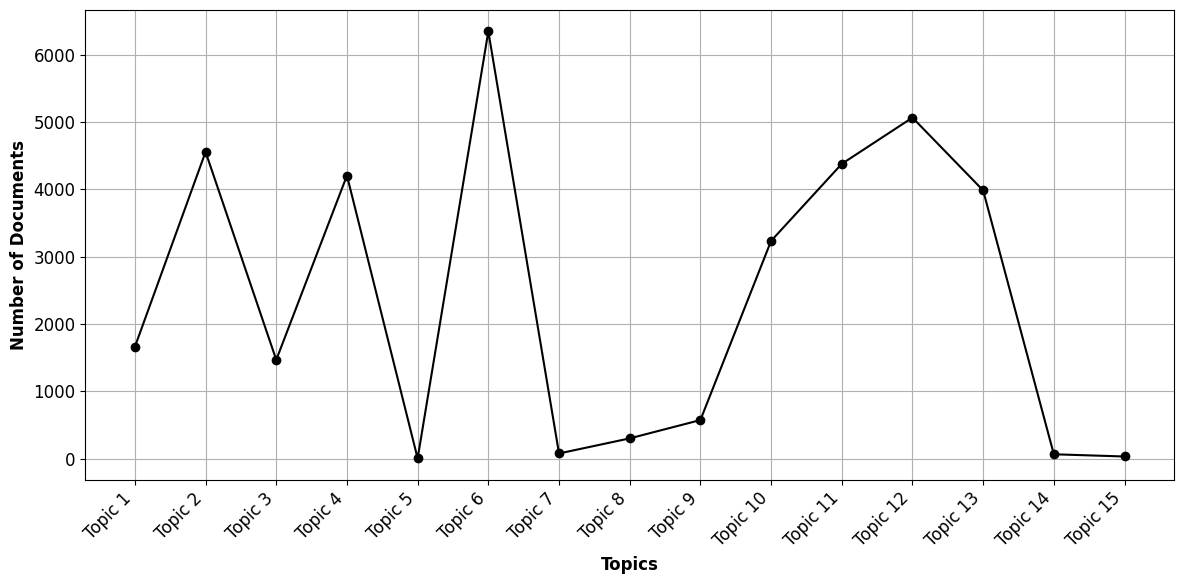

In [ ]:
import matplotlib.pyplot as plt

# Data
topics = [f'Topic {i}' for i in range(1, 16)]
document_counts = [1660, 4555, 1467, 4204, 4, 6345, 77, 301, 573, 3233, 4377, 5064, 3983, 65, 32]
# caption: Topic Distribution Across Documents in the Corpus
# Plotting
scaled_y_axis = np.arange(0, 7100, 100)
plt.figure(figsize=(12, 6))
plt.plot(topics, document_counts, marker='o', color='black', linestyle='-')
#plt.title('Number of Documents for Each Topic')
plt.xlabel('Topics', weight='bold')
plt.ylabel('Number of Documents', weight='bold')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:

dictionary = id2word

# Example preprocessed documents
preprocessed_docs = corpus

topics_and_documents = {}

# Example original documents
original_docs = dataset['Normalized Texts']

# Iterate over each topic
for topic_id in range(lda_model.num_topics):
    # Get the most representative document for the current topic
    top_documents = sorted(lda_model.get_topic_terms(topic_id, topn=10), key=lambda x: x[1], reverse=True)
    top_document_ids = [doc_id for doc_id, _ in top_documents]
    top_document_text = [doc for i, doc in enumerate(original_docs) if i in top_document_ids]
    # Print the topic ID and the most representative document
    topics_and_documents[topic_id] = top_document_text
    print(f"Topic {topic_id}: {top_document_text}")


Topic 0: ['lesson muslims', 'banglades dan rohingya mayk tidak asing lagi bagi org lnd yg tinggal dimalaysia kakak lotong carikan satu perempuan sy mau kawin kepala bapak kau lihat perempuan mate dah mcm berok', 'wow didn indonesians racist', 'india islamic countries protest human rights abuse india including al jazeera', 'bangladesh country world', 'bangladeshis rohingyas common illegally follow rules regulation ungrateful country feeds shelters india malaysia facing', 'dont land indonesian inch demand country', 'religion', 'rohingya muslim', 'stand gaza human rights']
Topic 1: ['chapter 0 sura god', 'rohingyas playing victim card', 'didn settle uninhabited island islands', 'sympathy united nations unhcr bring rohingnya country generous people tried help responsibility care using humanity trick realistic countries stand rohingya', 'thousands rohingya families lpg cylinders cook meals', 'broke rohingya refugee camp march report situation following affected rohingya refugee camp march u

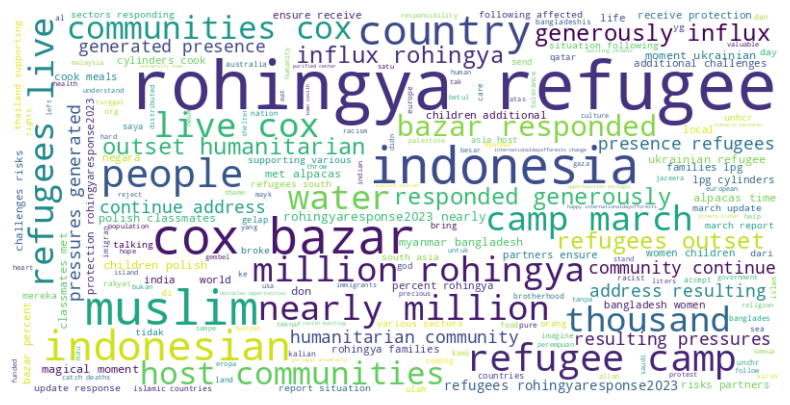

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all texts into one
all_texts_combined = ' '.join([' '.join(documents) for documents in topics_and_documents.values()])

# Check if all_texts_combined is empty
if not all_texts_combined:
    raise ValueError("The all_texts_combined variable is empty.")

# Create WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts_combined)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
#plt.title('Word Cloud for All Topics')
plt.axis('off')  # Hide axis
plt.show()


In [ ]:
# find the sentiment for all documents in each topic


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import math

# Set the number of topics to display per row
topics_per_row = 2

# Calculate the number of rows based on the number of topics and topics_per_row
num_topics = len(topics_and_documents)
num_rows = math.ceil(num_topics / topics_per_row)

# Create a single figure with subplots
fig, axes = plt.subplots(num_rows, topics_per_row, figsize=(15, 20))

# Flatten the axes array for easier indexing
axes = np.ravel(axes)

# Iterate over each topic
for topic_id, top_document_text in topics_and_documents.items():
    # Combine all documents in the topic into a single text
    topic_text = ' '.join(top_document_text)

    # Generate word cloud for the topic
    wordcloud = WordCloud(width=400, height=200, background_color='white').generate(topic_text)

    # Plot the word cloud on the corresponding subplot
    row_id = topic_id // topics_per_row
    col_id = topic_id % topics_per_row
    axes[row_id * topics_per_row + col_id].imshow(wordcloud, interpolation='bilinear')
    axes[row_id * topics_per_row + col_id].axis('off')
    axes[row_id * topics_per_row + col_id].set_title(f"Topic {topic_id}")

# Hide unused subplots
for i in range(num_topics, len(axes)):
    axes[i].axis('off')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


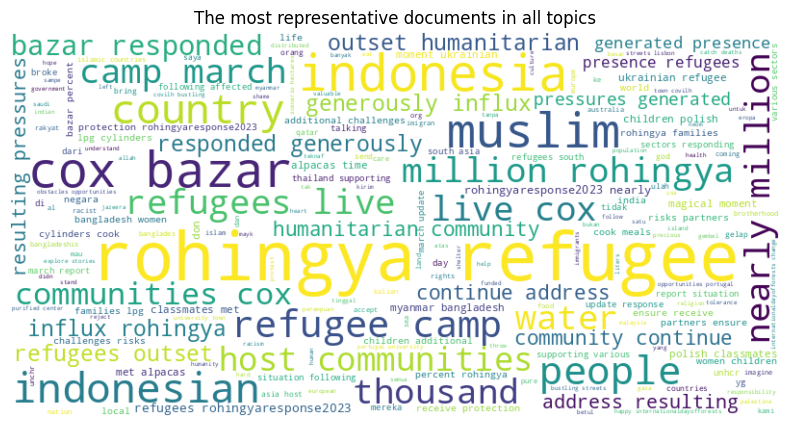

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# Combine all texts from different topics into a single text
all_texts = ' '.join([' '.join(top_document_text) for top_document_text in topics_and_documents.values()])

# Generate a word cloud for the combined text
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_texts)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("The most representative documents in all topics")
plt.show()


In [ ]:
texts=dataset['Normalized Texts']
# Loop over the topics and find the dominant document for each
for topic_num in range(lda_model.num_topics):
    topic_docs = lda_model.get_topic_terms(topic_num, topn=10)
    top_doc_id, _ = topic_docs[0]
    top_doc_text = texts[top_doc_id]
    print(f"Topic {topic_num}: {''.join(top_doc_text)}")

Topic 0: kerja diorang cuma asik merkaya biak tak tau risiko kedepan
Topic 1: chapter 0 sura god
Topic 2: ve million
Topic 3: pure racism prejudice
Topic 4: wow didn indonesians racist
Topic 5: indian understand issue indonesia
Topic 6: shame indonesians biggest muslim country world
Topic 7: height muslim brotherhood
Topic 8: myanmar left
Topic 9: qatar accept rohingya refugees
Topic 10: indonesia accept religion
Topic 11: ummah
Topic 12: shame indonesia
Topic 13: saudi arabia accepting aljajeera tell
Topic 14: help


In [ ]:
lda_model.get_topic_terms(0, topn=20)

In [ ]:
# Get the topic distribution for each document in the corpus
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus]

# Get the highest document probability for each topic
highest_prob_by_topic = []
for i in range(lda_model.num_topics):
    highest_prob = 0.0 # change it to 1.0 if you want to get the lowest
    for doc_topics in topic_distribution:
        for topic in doc_topics:
            if topic[0] == i and topic[1] > highest_prob: # change it to < if you want to get the lowest
                highest_prob = topic[1]
    highest_prob_by_topic.append(highest_prob)

# Print the highest document probability for each topic
for i, highest_prob in enumerate(highest_prob_by_topic):
    print(f"Topic {i+1}: = {highest_prob}")



Topic 1: = 0.4545414447784424
Topic 2: = 0.5172412991523743
Topic 3: = 0.2631572186946869
Topic 4: = 0.34883683919906616
Topic 5: = 0.45454493165016174
Topic 6: = 0.33333253860473633
Topic 7: = 0.4073718786239624
Topic 8: = 0.26315709948539734
Topic 9: = 0.3043473958969116
Topic 10: = 0.4193549156188965
Topic 11: = 0.44827598333358765
Topic 12: = 0.26315778493881226
Topic 13: = 0.3103446960449219
Topic 14: = 0.5675660967826843
Topic 15: = 0.2631573975086212


In [ ]:
# Filtering for words
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
# Create Topics
topics = [' '.join(t[0:15]) for t in words]

# Getting the topics
for id, t in enumerate(topics):
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
child family time hope birth donation imagine kick adult forever

------ Topic 1 ------
refugee rohingya care claim landslide fisherman inspiration thunder wind flash

------ Topic 2 ------
situation rohingyas instead stay island landslide academic wind flash thunder

------ Topic 3 ------
home leave welcome respect local pay flash thunder fisherman academic

------ Topic 4 ------
boat islamic religion talk come buddhist arrive ethnicity follow enemy

------ Topic 5 ------
country enter watch learn carry hard house demand academic flash

------ Topic 6 ------
bangladesh help free say wait hypocrite shout inspiration fisherman adversity

------ Topic 7 ------
muslim ummah sister thunder landslide flash fisherman wind dyk academic

------ Topic 8 ------
illegal job rich accept al_jazeera academic flash inspiration thunder dyk

------ Topic 9 ------
people kill bring stop responsibility try flash academic inspiration thunder

------ Topic 10 ------
day government bor

In [ ]:
# Filtering for words
topics_list={}
num_words = 10  # number of top words to print for each topic
for topic_idx in range(lda_model.num_topics):
    topic_terms = lda_model.get_topic_terms(topic_idx, topn=num_words)
    topic_words = [id2word.get(term_id) for term_id, _ in topic_terms]
    print(f"Topic {topic_idx+1}: {' '.join(topic_words)}")
    topics_list[topic_idx]=' '.join(topic_words)

Topic 1: child family time hope birth donation imagine kick adult forever
Topic 2: refugee rohingya care claim landslide fisherman inspiration thunder wind flash
Topic 3: situation rohingyas instead stay island landslide academic wind flash thunder
Topic 4: home leave welcome respect local pay flash thunder fisherman academic
Topic 5: boat islamic religion talk come buddhist arrive ethnicity follow enemy
Topic 6: country enter watch learn carry hard house demand academic flash
Topic 7: bangladesh help free say wait hypocrite shout inspiration fisherman adversity
Topic 8: muslim ummah sister thunder landslide flash fisherman wind dyk academic
Topic 9: illegal job rich accept al_jazeera academic flash inspiration thunder dyk
Topic 10: people kill bring stop responsibility try flash academic inspiration thunder
Topic 11: day government border send malaysian discover thunder landslide wind fish
Topic 12: support understand word victim landslide fisherman flash thunder adversity wind
Topic 

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# automatic topic labeling
from nltk.sentiment import SentimentIntensityAnalyzer

def get_sentiment_scores(term, sid):
    scores = sid.polarity_scores(term)
    #print(scores)
    return scores['pos'], scores['neg']

def assign_topic_name(topic, sid):
    terms = topic.split()
    sentiment_scores = {term: get_sentiment_scores(term, sid) for term in terms}

    # Calculate net sentiment score for each term
    net_sentiment_scores = {term: pos - neg for term, (pos, neg) in sentiment_scores.items()}

    # Find the term with the highest net sentiment score
    assigned_topic_name = max(net_sentiment_scores, key=net_sentiment_scores.get)

    return assigned_topic_name

# Sample topic
topic = "child family time hope birth donation imagine kick adult forever"

# Initialize the VADER sentiment intensity analyzer
sid = SentimentIntensityAnalyzer()


topics_=topics_list.values()
# Assign the topic name based on the term with the highest net sentiment score
for i, topic in enumerate(topics_):
  assigned_topic_name = assign_topic_name(topic, sid)
  # Print the result
  print(f"Topic {i+1}: {topic}")
  print(f"Assigned Topic Name: {assigned_topic_name}")


Topic 1: child family time hope birth donation imagine kick adult forever
Assigned Topic Name: hope
Topic 2: refugee rohingya care claim landslide fisherman inspiration thunder wind flash
Assigned Topic Name: care
Topic 3: situation rohingyas instead stay island landslide academic wind flash thunder
Assigned Topic Name: situation
Topic 4: home leave welcome respect local pay flash thunder fisherman academic
Assigned Topic Name: welcome
Topic 5: boat islamic religion talk come buddhist arrive ethnicity follow enemy
Assigned Topic Name: boat
Topic 6: country enter watch learn carry hard house demand academic flash
Assigned Topic Name: country
Topic 7: bangladesh help free say wait hypocrite shout inspiration fisherman adversity
Assigned Topic Name: help
Topic 8: muslim ummah sister thunder landslide flash fisherman wind dyk academic
Assigned Topic Name: muslim
Topic 9: illegal job rich accept al_jazeera academic flash inspiration thunder dyk
Assigned Topic Name: rich
Topic 10: people kil

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Extract the topic texts from the dictionary
topic_texts = list(topics_list.values())

# Create a CountVectorizer and transform the topic texts into a matrix of token counts
vectorizer = CountVectorizer()
topic_matrix = vectorizer.fit_transform(topic_texts)

# Calculate cosine similarity
cosine_sim_matrix = cosine_similarity(topic_matrix)

# Print the cosine similarity matrix
#print(cosine_sim_matrix)

# Print pairwise similarity scores




In [ ]:
import pandas as pd

# Convert the cosine similarity matrix to a DataFrame with topic IDs as row and column labels
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=topics_list.keys(), columns=topics_list.keys())

# Print the cosine similarity matrix
print("Cosine Similarity Matrix:")
print(cosine_sim_df)


Cosine Similarity Matrix:
     0    1    2    3    4    5    6    7    8    9    10   11   12   13   14
0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  1.0  0.4  0.3  0.0  0.1  0.2  0.5  0.3  0.3  0.3  0.5  0.2  0.0  0.4
2   0.0  0.4  1.0  0.3  0.0  0.2  0.0  0.5  0.3  0.3  0.3  0.4  0.1  0.0  0.4
3   0.0  0.3  0.3  1.0  0.0  0.2  0.1  0.4  0.3  0.3  0.1  0.3  0.2  0.0  0.3
4   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.1  0.2  0.2  0.0  1.0  0.0  0.2  0.2  0.2  0.0  0.1  0.0  0.0  0.2
6   0.0  0.2  0.0  0.1  0.0  0.0  1.0  0.1  0.1  0.1  0.0  0.2  0.1  0.0  0.1
7   0.0  0.5  0.5  0.4  0.0  0.2  0.1  1.0  0.4  0.3  0.3  0.5  0.2  0.0  0.4
8   0.0  0.3  0.3  0.3  0.0  0.2  0.1  0.4  1.0  0.4  0.1  0.2  0.1  0.0  0.4
9   0.0  0.3  0.3  0.3  0.0  0.2  0.1  0.3  0.4  1.0  0.1  0.2  0.1  0.0  0.4
10  0.0  0.3  0.3  0.1  0.0  0.0  0.0  0.3  0.1  0.1  1.0  0.3  0.1  0.0  0.3
11  0.0  0.5  0.4  0.3  0.0  0.1  0.2 

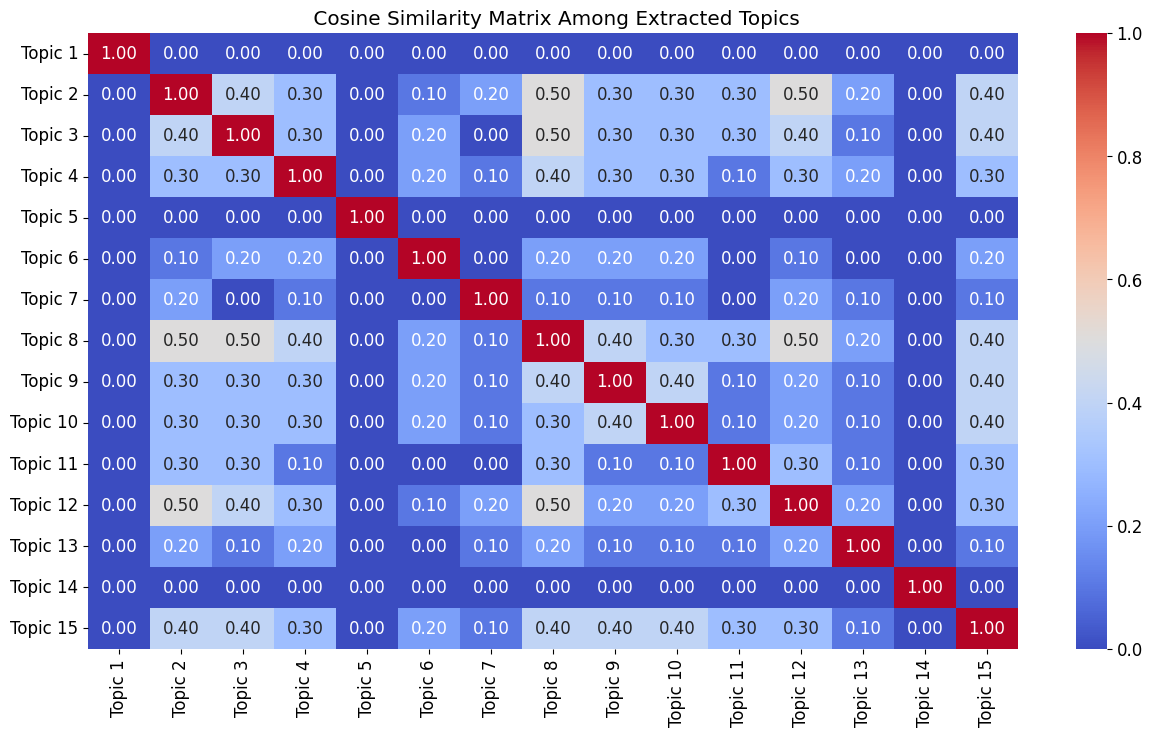

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



topics_list = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 4: 'Topic 5',
               5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 8: 'Topic 9', 9: 'Topic 10',
               10: 'Topic 11', 11: 'Topic 12', 12: 'Topic 13', 13: 'Topic 14', 14: 'Topic 15'}

# Convert the cosine similarity matrix to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=topics_list.keys(), columns=topics_list.keys())

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(cosine_sim_df, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=topics_list.values(), yticklabels=topics_list.values())
plt.title(' Cosine Similarity Matrix Among Extracted Topics')
plt.show()


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

def get_sentiment_vader(topic):
    analyzer = SentimentIntensityAnalyzer()
    # Get the sentiment polarity score
    sentiment_score = analyzer.polarity_scores(topic)['compound']

    # Classify the sentiment as positive, negative, or neutral based on the compound score
    if sentiment_score >= 0.05:
        return sentiment_score # positive
    elif sentiment_score <= -0.05:
        return sentiment_score # negative
    else:
        return sentiment_score # neutral

# List of topics
topics_lst = topics_list.values()

# Perform sentiment analysis for each topic using VADER
sentiments = [get_sentiment_vader(topic) for topic in topics_lst]

# Display the results
for i, topic in enumerate(topics_lst):
    print(f"Topic {i+1}: {topic}--Sentiment: {sentiments[i]}")


Topic 1: child family time hope birth donation imagine kick adult forever--Sentiment: 0.4404
Topic 2: refugee rohingya care claim landslide fisherman inspiration thunder wind flash--Sentiment: 0.765
Topic 3: situation rohingyas instead stay island landslide academic wind flash thunder--Sentiment: 0.0
Topic 4: home leave welcome respect local pay flash thunder fisherman academic--Sentiment: 0.6705
Topic 5: boat islamic religion talk come buddhist arrive ethnicity follow enemy--Sentiment: -0.5423
Topic 6: country enter watch learn carry hard house demand academic flash--Sentiment: -0.2263
Topic 7: bangladesh help free say wait hypocrite shout inspiration fisherman adversity--Sentiment: 0.765
Topic 8: muslim ummah sister thunder landslide flash fisherman wind dyk academic--Sentiment: 0.0
Topic 9: illegal job rich accept al_jazeera academic flash inspiration thunder dyk--Sentiment: 0.7184
Topic 10: people kill bring stop responsibility try flash academic inspiration thunder--Sentiment: -0.

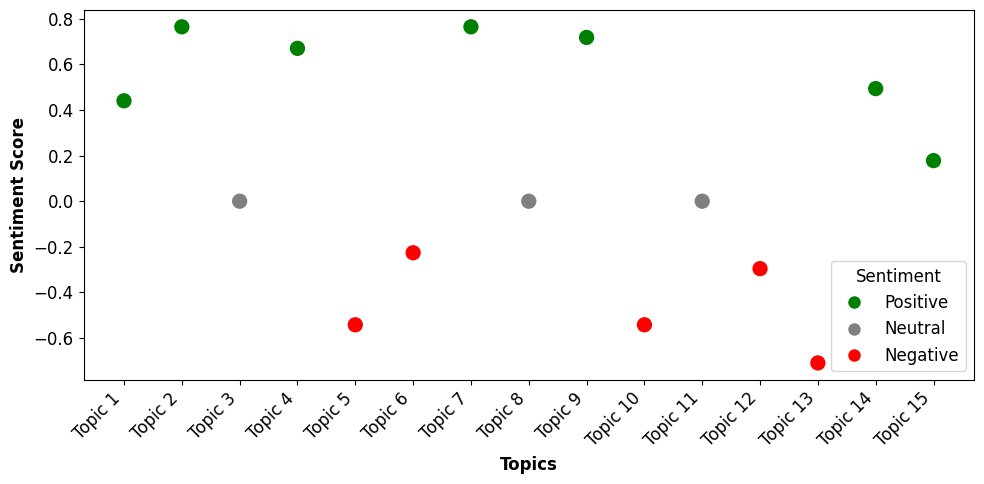

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
topics = ["Topic 1", "Topic 2", "Topic 3", "Topic 4", "Topic 5",
          "Topic 6", "Topic 7", "Topic 8", "Topic 9", "Topic 10",
          "Topic 11", "Topic 12", "Topic 13", "Topic 14", "Topic 15"]

sentiments = ["Positive", "Positive", "Neutral", "Positive", "Negative",
              "Negative", "Positive", "Neutral", "Positive", "Negative",
              "Neutral", "Negative", "Negative", "Positive", "Positive"]

sentiment_scores = [0.4404, 0.765, 0.0, 0.6705, -0.5423, -0.2263, 0.765, 0.0, 0.7184, -0.5423, 0.0, -0.296, -0.7096, 0.4939, 0.1779]

# Convert sentiment labels to numerical values for plotting
sentiment_colors = {'Positive': 'green', 'Neutral': 'gray', 'Negative': 'red'}
colors = [sentiment_colors[sentiment] for sentiment in sentiments]

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
scatter = ax.scatter(np.arange(len(topics)), sentiment_scores, c=colors, s=100)

# Create legend with right bottom corner positioning
legend_labels = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=sentiment)
                 for sentiment, color in sentiment_colors.items()]
ax.legend(handles=legend_labels, title='Sentiment', loc='lower right')

# Set x-axis ticks and labels
ax.set_xticks(np.arange(len(topics)))
ax.set_xticklabels(topics, rotation=45, ha='right')

# Set y-axis label
ax.set_ylabel('Sentiment Score', weight='bold')
ax.set_xlabel('Topics', weight='bold')

# Display the plot
#plt.title('Sentiment Analysis of Topics with Scores')
plt.tight_layout()  # Ensures that the legend does not overlap with the plot
plt.show()


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Program to measure the similarity between
# two sentences using cosine similarity.
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# X = input("Enter first string: ").lower()
# Y = input("Enter second string: ").lower()
X ="food provide hope aid feel sea arrive demand imagine al_jazeera"
Y ="refugee boat right care come claim land follow stay loading"

# tokenization
X_list = word_tokenize(X)
Y_list = word_tokenize(Y)

# sw contains the list of stopwords
sw = stopwords.words('english')
l1 =[];l2 =[]

# remove stop words from the string
X_set = {w for w in X_list if not w in sw}
Y_set = {w for w in Y_list if not w in sw}

# form a set containing keywords of both strings
rvector = X_set.union(Y_set)
for w in rvector:
	if w in X_set: l1.append(1) # create a vector
	else: l1.append(0)
	if w in Y_set: l2.append(1)
	else: l2.append(0)
c = 0

# cosine formula
for i in range(len(rvector)):
		c+= l1[i]*l2[i]
cosine = c / float((sum(l1)*sum(l2))**0.5)
print("similarity: ", cosine)


similarity:  0.0


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -83.53317021355198

Coherence Score:  0.5889835723289617


In [ ]:
print(lda_model.alpha)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
print(lda_model.eta)

[0.04678712 0.0493502  0.04982478 ... 0.04678737 0.04678737 0.04678728]


In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, n_jobs=1)
pyLDAvis.save_html(vis, 'output_ldamodel.html')
vis


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
1      0.320706  0.314120       1        1  9.223732
9      0.143444 -0.047881       2        1  7.875318
0      0.025928 -0.002636       3        1  7.282344
6      0.240630 -0.345859       4        1  7.229044
13     0.024147 -0.002289       5        1  6.962475
5      0.062935 -0.011283       6        1  6.903325
3     -0.065933  0.009504       7        1  6.464101
10    -0.029812  0.005734       8        1  6.462919
12    -0.046270  0.007660       9        1  6.354341
11    -0.052489  0.008191      10        1  6.291062
4     -0.077726  0.010564      11        1  6.174042
2     -0.114318  0.012826      12        1  5.798478
8     -0.139669  0.013759      13        1  5.742509
14    -0.152530  0.013861      14        1  5.708240
7     -0.139045  0.013729      15        1  5.528070, topic_info=           Term         Freq        Total Category  logprob  loglift
11      refugee  2534.000000  2534.000000  Default  30.0000  30.0000
101  bangladesh  1608.000000  1608.000000  Default  29.0000  29.0000
5        people  1662.000000  1662.000000  Default  28.0000  28.0000
0       country  1536.000000  1536.000000  Default  27.0000  27.0000
18      support  1452.000000  1452.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
17         stay     0.097753   240.419238  Topic15  -9.8989  -4.9124
18      support     0.097753  1452.185414  Topic15  -9.8989  -6.7108
20   indonesian     0.097753   274.474502  Topic15  -9.8989  -5.0448
22        right     0.097753   231.291766  Topic15  -9.8989  -4.8737
23         wait     0.097753    39.607741  Topic15  -9.8989  -3.1090

[752 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
10       13  0.997654      accept
154       3  0.895398       adult
112       5  0.998741         aid
83       13  0.994311  al_jazeera
141      11  0.990972      arrive
...     ...       ...         ...
23        4  0.984656        wait
163       6  0.992697       watch
3         7  0.995719     welcome
164       9  0.999394       woman
39       10  0.989063        word

[99 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 1, 7, 14, 6, 4, 11, 13, 12, 5, 3, 9, 15, 8])

`Symmetric alpha` means that all topics are equally likely to be assigned to a document. This can lead to a more balanced distribution of topics across documents.

`Asymmetric alpha` means that some topics are more likely to be assigned to a document than others. This can be useful when there are certain topics that are expected to be more prevalent in certain documents.

`Symmetric beta` means that all words are equally likely to be assigned to a topic. This can lead to a more balanced distribution of words across topics.

`Asymmetric beta` means that some words are more likely to be assigned to a topic than others. This can be useful when there are certain words that are more strongly associated with certain topics.

In [ ]:
!pip install gensim -U

In [ ]:
#Non-negative Matrix Factorization (NMF),
from gensim.models import Nmf


# Create a dictionary from the preprocessed documents
dictionary = id2word



# Train an NMF model with k topics
for k in range(1,31,1):
  nmf = Nmf(corpus, num_topics=k, chunksize=100)
  # Calculate the coherence score for the model
  coherence_model = CoherenceModel(model=nmf, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
  coherence_score = coherence_model.get_coherence()
  print(f"{k}={coherence_score}")
# best coherence 0.412 for 33 topics

1=0.4497670122273883
2=0.4316299696542307
3=0.4140579806810795
4=0.4084607490939526
5=0.38940873372858353
6=0.33742066464656206
7=0.3767691582258713
8=0.3542668491703768
9=0.33209701142380654
10=0.34467061236630364
11=0.30734192583807696
12=0.3359972376807134
13=0.3432529806574235
14=0.3352457266672693
15=0.3421005117774232
16=0.3355481203025452
17=0.3411899575756387
18=0.34612006728728073
19=0.32898372606437654
20=0.34870657577807385
21=0.34090453519462144
22=0.35313515562394593
23=0.3596474472593274
24=0.36954334578289133
25=0.3586334011639634
26=0.37415423900497785
27=0.3540815030289867
28=0.3665623775330466
29=0.3543519501704791
30=0.376662093077205


In [ ]:
from gensim.models import LsiModel
#n_topic=10

for n_topic in range(1,31,1):
  lsa_model = LsiModel(corpus, num_topics=n_topic, chunksize=100, id2word=id2word)
  coherence_model = CoherenceModel(model=lsa_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_score = coherence_model.get_coherence()
  print(f"{n_topic}={coherence_score}")

1=0.5457157401280623
2=0.4107918951265032
3=0.3834183690069577
4=0.5404686691461712
5=0.4499929387231717
6=0.4804357830764328
7=0.5045995396113734
8=0.4397300688318446
9=0.43990353728473475
10=0.4357385921415203
11=0.42289263332008975
12=0.4474888663970578
13=0.46241998348526203
14=0.4094991338448275
15=0.39057236726749117
16=0.405197944353139
17=0.4137914524154817
18=0.4283099520130621
19=0.4185130093340501
20=0.38522574684054806
21=0.38297193532899554
22=0.3913294309079491
23=0.39498338717601145
24=0.396539117626508
25=0.36663986785272584
26=0.35902590787152033
27=0.36081377996268693
28=0.3638773094348958
29=0.3700008020311941
30=0.36149831923604947


In [ ]:
#Hierarchical Dirichlet Process
from gensim.models import HdpModel
for n_topic in range(1,31,1):
  hdp_model = HdpModel(corpus, id2word, max_chunks=None, max_time=None, chunksize=100,
                     kappa=1.0, tau=64.0, K=15, T=n_topic, alpha=1, gamma=1,
                     eta=0.01, scale=1.0, var_converge=0.0001,
                     outputdir=None, random_state=None)
  coherence_model = CoherenceModel(model=hdp_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
  coherence_score = coherence_model.get_coherence()
  print(f"{len(hdp_model.get_topics())}={coherence_score}")

In topic modeling, the chunksize parameter determines the number of documents processed at a time during training. It is an important parameter that can affect both the quality and efficiency of the model.

When training a topic model on a large corpus of text, the entire corpus is usually divided into smaller subsets, or "chunks," that can be processed more efficiently. The chunksize parameter determines the size of these chunks.

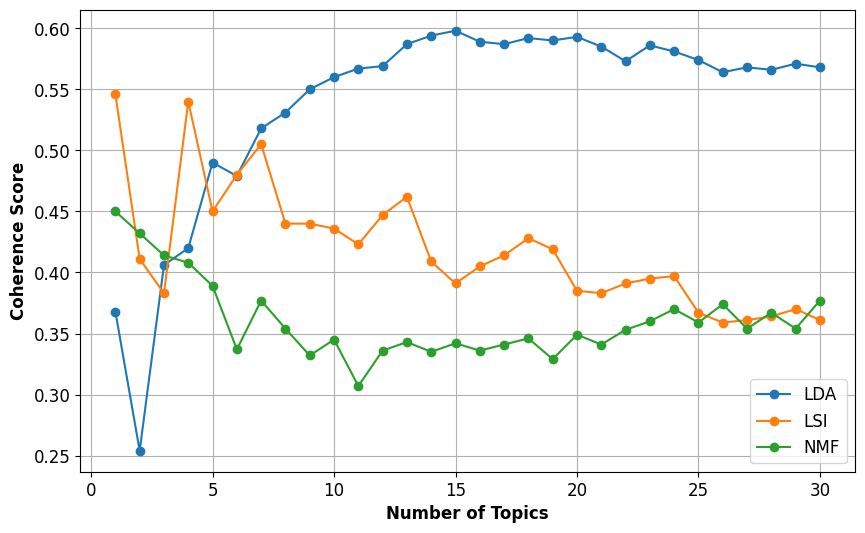

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your data
data = np.array([
    [0.368, 0.546, 0.450],
    [0.254, 0.411, 0.432],
    [0.406, 0.383, 0.414],
    [0.420, 0.540, 0.408],
    [0.490, 0.450, 0.389],
    [0.479, 0.480, 0.337],
    [0.518, 0.505, 0.377],
    [0.531, 0.440, 0.354],
    [0.550, 0.440, 0.332],
    [0.560, 0.436, 0.345],
    [0.567, 0.423, 0.307],
    [0.569, 0.447, 0.336],
    [0.587, 0.462, 0.343],
    [0.594, 0.409, 0.335],
    [0.598, 0.391, 0.342],
    [0.589, 0.405, 0.336],
    [0.587, 0.414, 0.341],
    [0.592, 0.428, 0.346],
    [0.590, 0.419, 0.329],
    [0.593, 0.385, 0.349],
    [0.585, 0.383, 0.341],
    [0.573, 0.391, 0.353],
    [0.586, 0.395, 0.360],
    [0.581, 0.397, 0.370],
    [0.574, 0.367, 0.359],
    [0.564, 0.359, 0.374],
    [0.568, 0.361, 0.354],
    [0.566, 0.364, 0.367],
    [0.571, 0.370, 0.354],
    [0.568, 0.361, 0.377]
])

# Extracting the three columns
lda = data[:, 0]
lsi = data[:, 1]
nmf = data[:, 2]

# Creating the x-axis values
num_topics = np.arange(1, 31)

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(num_topics, lda, marker='o', label='LDA')
plt.plot(num_topics, lsi, marker='o', label='LSI')
plt.plot(num_topics, nmf, marker='o', label='NMF')

# Adding labels and title
plt.xlabel('Number of Topics', weight='bold')
plt.ylabel('Coherence Score', weight='bold')
#plt.title('LDA, LSI, and NMF values over the number of topics')

# Adding a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()
